# Colaboratoryで実行する場合
以下を実行して、外部ファイルをダウンロードしてください。   
**このセルはColaboratoryを起動するたびに必要となります**   
**「ランタイム＞ランタイムのタイプを変更」で「ハードウェアアクセラレータ」をGPUにしてから実行することをお勧めします。**

In [ ]:
##################################
### Colaboratoryのみ以下を実行 ###
##################################
import sys
if 'google.colab' in sys.modules:
    !wget -P ./img http://www.hal.t.u-tokyo.ac.jp/~yamakata/lecture/mediaproc/mediaproc6/mediaproc6-MobileNetSSD.zip
    !unzip img/mediaproc6-MobileNetSSD.zip -d img/

# Single-Shot multi-box Detector (SSD) を試してみよう！


Single-Shot multi-box Detector(SSD)とは、Deep Learningによる画像の領域検出アルゴリズムの一種です。   
ここではGoogleにより高速化されたアルゴリズムであるMobileNetを使って、SSDを体験してみましょう。

- SSDの論文：Wei Liu, Dragomir Anguelov, Dumitru Erhan, Christian Szegedy, Scott Reed, Cheng-Yang Fu, Alexander C. Berg, "SSD: Single Shot MultiBox Detector", ECCV2016. view on https://link.springer.com/chapter/10.1007/978-3-319-46448-0_2 or https://arxiv.org/abs/1512.02325
- Mobile Netの論文：Andrew G. Howard, Menglong Zhu, Bo Chen, Dmitry Kalenichenko, Weijun Wang, Tobias Weyand, Marco Andreetto, Hartwig Adam. (17 Apr 2017). “MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications”. Computer Vision and Pattern Recognition. view on https://arxiv.org/abs/1704.04861

Deep Learningによる画像認識にはいろいろなプラットフォームと実装がありますが、
ここではopencv3.3以上に組み込まれたDeep LearningのライブラリCaffeを使いたいと思います。   
物体検出プログラムを実行するには、学習済みのモデルとプロトテキストが必要です。

- prototxt: ニューラルネットの構造を記述するためのCaffe独自のテキスト形式
- caffeemodel: Caffe形式の学習済みモデル

今回使用するモデルは、Microsoftが提供している画像のデータセット[MS-COCO](http://cocodataset.org/#home)で学習したのち、[Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/)というデータセットでfine-tuneしたモデルです。   
Pascal VOCは、背景（background)に加え、以下の20種類の物体について、その領域（bouding-box)とラベルが指定されたデータセットです。   

```"background", "aeroplane", "bicycle", "bird", "boat","bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"```
            
ですので、これらの20種類のみ物体の領域検出が可能ということになります。

モデルやプロトテキストは以下に置かれたものをダウンロードして使用します。   
[https://github.com/chuanqi305/MobileNet-SSD](https://github.com/chuanqi305/MobileNet-SSD)

## 1. モデルのダウンロード

学習済みのモデルをダウンロードします。   
以下を**1回のみ**実行してください。  
ダウンロードされたモデルは、このnotebookが置かれているフォルダ内にある、MobileNet-SSDという名前のフォルダの下に入ります。

In [1]:
# この作業は1回のみで結構です！1回だけ、以下のコードの最初と最後にある「'''」を消してから実行してください。


import urllib.request
import os

if not os.path.exists('MobileNet-SSD'):
    os.mkdir('MobileNet-SSD')

# モデルのダウンロード元
caffemodel_link = 'https://github.com/chuanqi305/MobileNet-SSD/raw/master/mobilenet_iter_73000.caffemodel'
prototxt_link = 'https://raw.githubusercontent.com/chuanqi305/MobileNet-SSD/master/deploy.prototxt'
license_link = 'https://github.com/chuanqi305/MobileNet-SSD/blob/master/LICENSE'

# モデルのダウンロード先
caffemodel_save = 'MobileNet-SSD/mobilenet_iter_73000.caffemodel'
prototxt_save = 'MobileNet-SSD/deploy.prototxt'
license_save = 'MobileNet-SSD/LICENSE'

# ダウンロードの実行
urllib.request.urlretrieve(caffemodel_link, caffemodel_save)
urllib.request.urlretrieve(prototxt_link, prototxt_save)
urllib.request.urlretrieve(license_link, license_save)


('MobileNet-SSD/LICENSE', <http.client.HTTPMessage at 0x1a26033b808>)

## 2. 実行プログラム

引数として与えられたprototxtとmodelを使い、入力画像imageについて物体検出する関数`DNN_ObjectDetection`を以下のように定義します。

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np

def DNN_ObjectDetection(image, prototxt, model, confidence):
    inWidth = 300
    inHeight = 300
    inScaleFactor = 0.007843
    meanVal = 127.5
    
    # Pascal VOCで検出対象となっている２０クラスと背景(background)
    labels = ['background', 
              'aeroplane', 'bicycle', 'bird', 'boat','bottle', 'bus', 'car', 'cat', 'chair', 'cow', 
              'dining table','dog', 'horse', 'motorbike', 'person', 'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']
    label_colors = np.random.uniform(0, 255, size=(len(labels), 3)) # それぞれのラベルに適当な色を割り当てる

    # 画像の読み込み
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    (h, w) = image.shape[:2] # 画像サイズの取得

    # ネットワークの準備
    dnn = cv2.dnn.readNetFromCaffe(prototxt, model)

    # 画像を300x300にリサイズし、正規化してblob形式に変換
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (inWidth, inHeight)), inScaleFactor, (inWidth, inHeight), meanVal)
    dnn.setInput(blob)
    
    # 領域の検出
    detections = dnn.forward()

    # 検出された各領域について、画像上に矩形とラベルを描画
    for i in np.arange(0, detections.shape[2]):
        # confidenceがあらかじめ定めた値よりも大きい場合のみ
        if detections[0, 0, i, 2] > confidence:
            idx = int(detections[0, 0, i, 1]) # 検出された領域のクラス番号
            print('クラス名：{}\t 信頼度：{:.2f}%'.format(labels[idx], detections[0, 0, i, 2] * 100))

            # 検出された領域の対角２点の座標を獲得
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h]) 
            (bbox_X1, bbox_Y1, bbox_X2, bbox_Y2) = box.astype('int')
            # 検出された領域の輪郭線を描画
            cv2.rectangle(image, (bbox_X1, bbox_Y1), (bbox_X2, bbox_Y2), label_colors[idx], 2)
            # 検出された領域のラベルを描画
            y = bbox_Y1 - 15 if bbox_Y1 - 15 > 15 else bbox_Y1 + 15 # ラベルの描画位置
            cv2.putText(image, labels[idx], (bbox_X1, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, label_colors[idx], 2)

    # 画像の描画
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    cv2.imwrite('img/MobileNet-SDD.jpg', cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

## 3. 画像の領域検出の実行

入力画像をいろいろと変えて結果の変わり方を見てみましょう。   
また、信頼度も変えてみましょう。

クラス名：bird	 信頼度：58.12%
クラス名：dog	 信頼度：99.42%
クラス名：dog	 信頼度：99.24%
クラス名：dog	 信頼度：94.13%


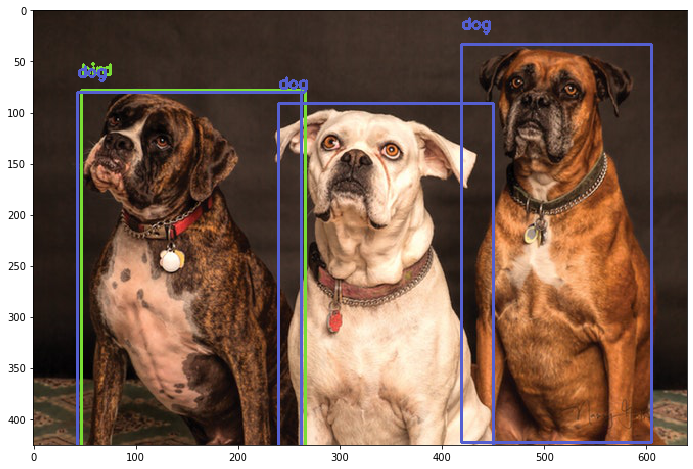

In [7]:
# 検出した領域の信頼度に対する閾値（この値以上の信頼度の領域はOKとする）
confidence = 0.2

image = 'img/adorable-animal-blur-850602.jpg' # https://www.pexels.comより取得
#image = 'img/animals-cats-cute-45170.jpg' # https://www.pexels.comより取得
#image = 'img/aeroplanes-aircraft-airline-163792.jpg' # https://www.pexels.comより取得
#image = 'img/bangkok-buildings-cars-708764.jpg' # https://www.pexels.comより取得
#image = "img/1024px-Super_Tuesday_(6814264898).jpg" # https://upload.wikimedia.org/wikipedia/commons/thumb/a/a4/Super_Tuesday_%286814264898%29.jpg/1024px-Super_Tuesday_%286814264898%29.jpg より取得

prototxt="MobileNet-SSD/deploy.prototxt"
model="MobileNet-SSD/mobilenet_iter_73000.caffemodel"

DNN_ObjectDetection(image, prototxt, model, confidence)